In [14]:
import sys
import subprocess

# Questo comando gestisce automaticamente gli spazi nel percorso
subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels"])

0

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Stile grafici
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Caricamento
df = pd.read_csv('EnergyConsumption.csv') # Aggiusta il percorso se serve
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime').sort_index()

# Feature Engineering base
df['hour'] = df.index.hour
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['year'] = df.index.year

# Creiamo la colonna 'Season' per i grafici
df['season'] = df['month'].apply(lambda x: 'Estate' if x in [6,7,8] else ('Inverno' if x in [12,1,2] else 'Altro'))

print("Dataset pronto. Range temporale:", df.index.min(), " - ", df.index.max())

Dataset pronto. Range temporale: 2004-10-01 01:00:00  -  2018-08-03 00:00:00


C:\Users\Rei Mici\AppData\Local\Temp\ipykernel_16344\524937669.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean(numeric_only=True)
C:\Users\Rei Mici\AppData\Local\Temp\ipykernel_16344\524937669.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df['AEP_MW'].resample('M').mean()


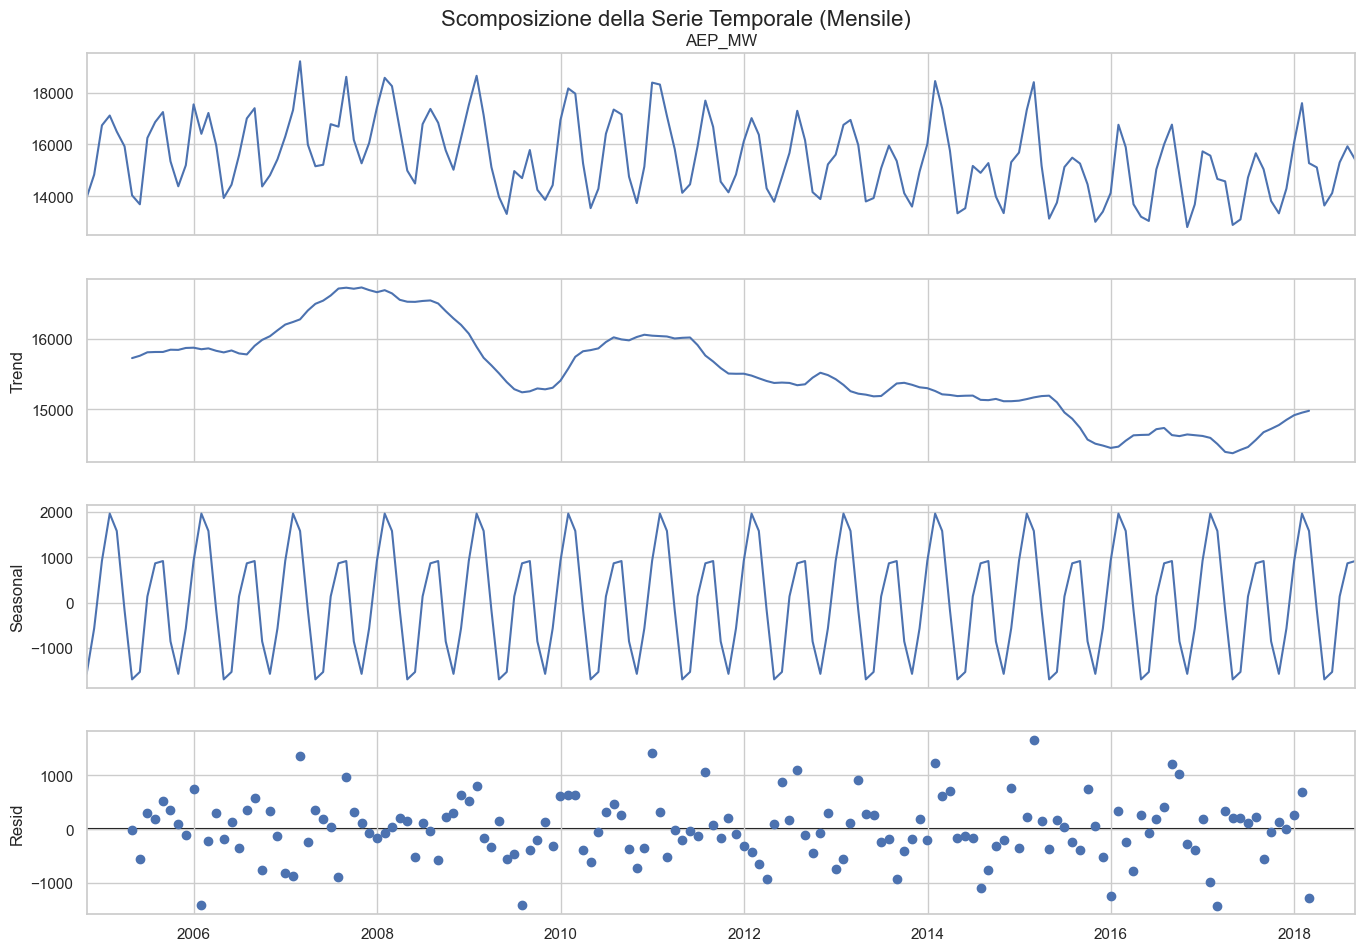

In [16]:
# Cella 2: Analisi Stagionalità (Corretta)

# Specifichiamo (numeric_only=True) per evitare che provi a fare la media del testo "Estate/Inverno"
df_monthly = df.resample('M').mean(numeric_only=True)

# Oppure, ancora meglio, selezioniamo solo la colonna che ci interessa prima di fare il resample
# Questo è il metodo più sicuro:
monthly_data = df['AEP_MW'].resample('M').mean()

# Decomposizione (Trend, Stagionalità, Residuo)
decomposition = seasonal_decompose(monthly_data, model='additive', period=12)

# Plot
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Scomposizione della Serie Temporale (Mensile)', fontsize=16)
plt.show()

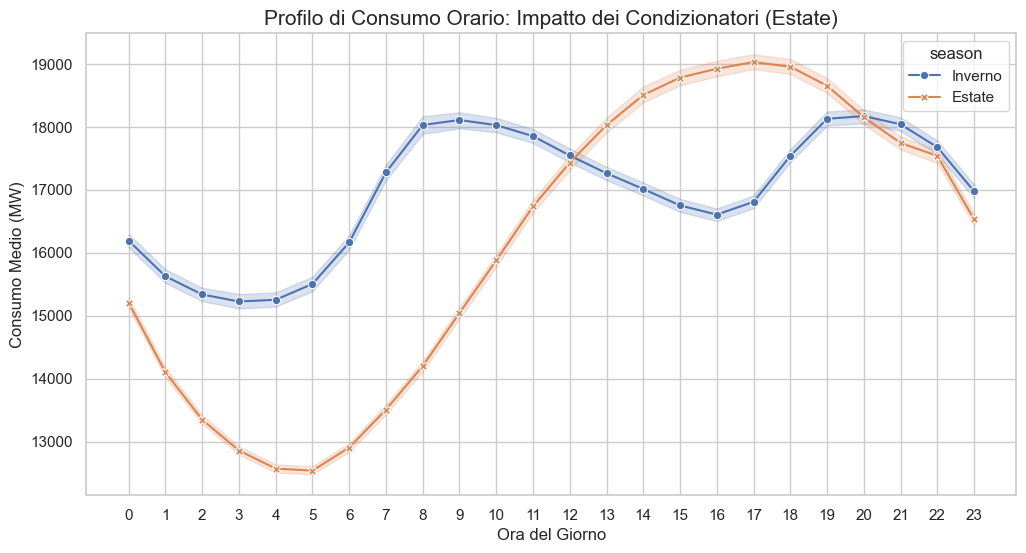

In [17]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df[df['season'].isin(['Estate', 'Inverno'])], 
             x='hour', y='AEP_MW', hue='season', style='season', markers=True, dashes=False)
plt.title('Profilo di Consumo Orario: Impatto dei Condizionatori (Estate)', fontsize=15)
plt.ylabel('Consumo Medio (MW)')
plt.xlabel('Ora del Giorno')
plt.grid(True)
plt.xticks(range(0,24))
plt.show()

Addestramento in corso...


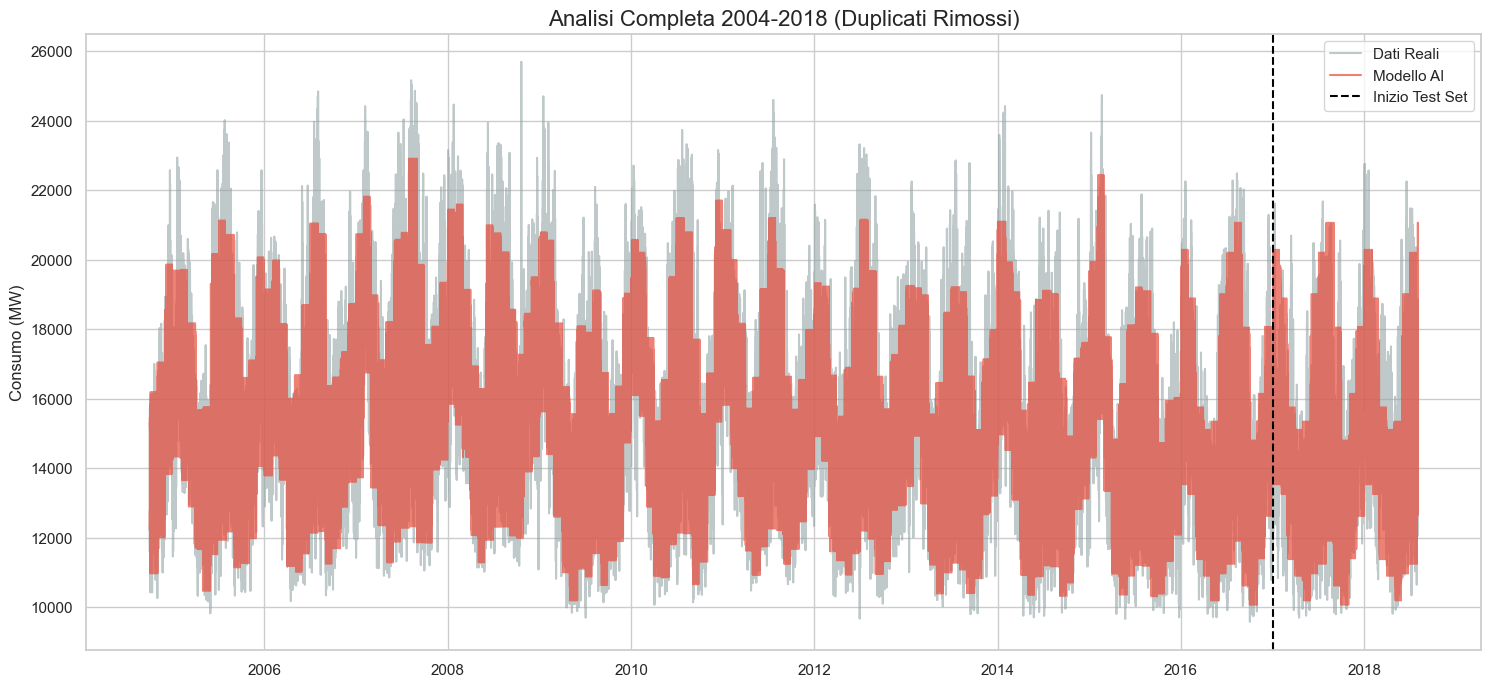

--- Risultati sul Test Set ---
Errore Medio Assoluto (MAE): 1256.20 MW
Errore Medio Percentuale (MAPE): 8.36%


In [19]:
# Cella 4 (Corretta e "A prova di duplicati")

# --- PASSO CRUCIALE: Pulizia Duplicati ---
# Rimuoviamo eventuali orari doppi (es. cambio ora legale) mantenendo solo il primo trovato
df = df[~df.index.duplicated(keep='first')]
# -----------------------------------------

# 1. Feature Engineering
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year
df['quarter'] = df.index.quarter

# 2. Split Temporale
split_date = '2017-01-01'

train = df.loc[df.index < split_date].copy()
test = df.loc[df.index >= split_date].copy()

# 3. Addestramento
features = ['hour', 'dayofweek', 'quarter', 'month', 'year']
model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
print("Addestramento in corso...")
model.fit(train[features], train['AEP_MW'])

# 4. Predizione su TUTTO il dataset
# Ora non darà errore perché abbiamo rimosso i duplicati dall'indice
df['prediction'] = model.predict(df[features])

# Copiamo le predizioni nel test set per calcolare l'errore
test['prediction'] = df.loc[test.index, 'prediction']

# 5. Visualizzazione Totale
plt.figure(figsize=(18, 8))
plt.plot(df.index, df['AEP_MW'], label='Dati Reali', color='#95a5a6', alpha=0.6)
plt.plot(df.index, df['prediction'], label='Modello AI', color='#e74c3c', alpha=0.7)
plt.axvline(pd.to_datetime(split_date), color='black', linestyle='--', label='Inizio Test Set')
plt.title('Analisi Completa 2004-2018 (Duplicati Rimossi)', fontsize=16)
plt.ylabel('Consumo (MW)')
plt.legend()
plt.show()

# 6. Calcolo Metriche
mae = mean_absolute_error(test['AEP_MW'], test['prediction'])
mape = np.mean(np.abs((test['AEP_MW'] - test['prediction']) / test['AEP_MW'])) * 100

print(f"--- Risultati sul Test Set ---")
print(f"Errore Medio Assoluto (MAE): {mae:.2f} MW")
print(f"Errore Medio Percentuale (MAPE): {mape:.2f}%")